In [233]:
import xgboost
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
import pandas as pd
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix

In [234]:
dataframe = pd.read_csv('Data/Churn_Modelling.csv')

In [235]:
dataframe.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


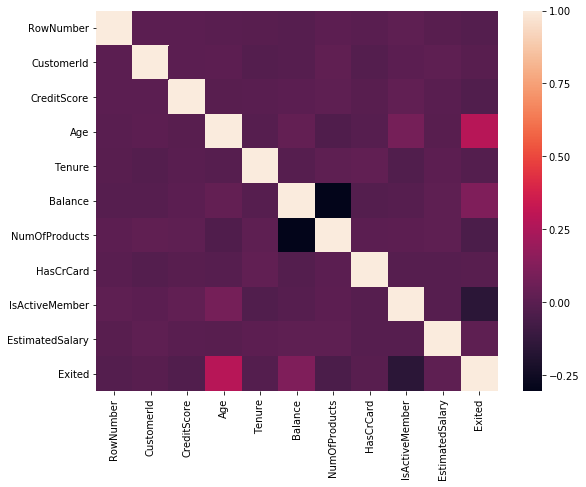

In [236]:
plt.figure(figsize=(9,7))
sns.heatmap(dataframe.corr())

In [237]:

dataframe,test = train_test_split(dataframe,test_size=0.05,random_state=0)

In [238]:
test.to_csv('Data/test.csv')

In [239]:
X = dataframe.drop(['Exited'],axis=1)
y = dataframe['Exited']

In [240]:
X.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
799,800,15567367,Tao,601,Germany,Female,42,9,133636.16,1,0,1,103315.74
1069,1070,15628674,Iadanza,844,France,Male,40,7,113348.14,1,1,0,31904.31
8410,8411,15609913,Clark,743,France,Female,46,9,0.00,1,1,0,113436.08
9436,9437,15771000,Powell,684,France,Male,38,4,0.00,3,1,0,75609.84
5099,5100,15731555,Ross-Watt,595,Germany,Female,45,9,106000.12,1,0,0,191448.96


In [241]:
# function to remove cols having less correlation
num_col = (X.columns[X.dtypes=='int64'])
for i in num_col:
    if (dataframe.corr()['Exited'][i] < -0.02):
        X=X.drop([i],axis=1)

In [242]:
X.head()

,RowNumber,CustomerId,Surname,Geography,Gender,Age,Tenure,Balance,HasCrCard,EstimatedSalary
799,800,15567367,Tao,Germany,Female,42,9,133636.16,0,103315.74
1069,1070,15628674,Iadanza,France,Male,40,7,113348.14,1,31904.31
8410,8411,15609913,Clark,France,Female,46,9,0.00,1,113436.08
9436,9437,15771000,Powell,France,Male,38,4,0.00,1,75609.84
5099,5100,15731555,Ross-Watt,Germany,Female,45,9,106000.12,0,191448.96


In [243]:
X.shape

(9500, 10)

In [244]:
X.nunique()

RowNumber          9500
CustomerId         9500
Surname            2865
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6059
HasCrCard             2
EstimatedSalary    9499
dtype: int64

In [245]:
X.drop(['Surname','CustomerId'],axis=1,inplace=True)

In [246]:
X.columns

Index(['RowNumber', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'HasCrCard', 'EstimatedSalary'],
      dtype='object')

In [247]:
class pre_process:
    
    def __init__(self):
        self.cols = ['Geography','Gender']
        self.needed_cols= ['Age', 'Tenure', 'Geography','Gender','Balance', 'HasCrCard', 'EstimatedSalary']
        self.added_cols=[]
    
    def pre_processing(self,X):
        models= []
        added_cols = []
        X = X[self.needed_cols]
#         print(X.head())
        for col in self.cols:
            sorted_col = np.sort(X[col].unique())
            lb = LabelBinarizer()
            lb.fit(X[col])
            binarized = lb.transform(X[col])
            models.append(lb)
            for i in range(0,len(sorted_col)-1):
                X[sorted_col[i]]=binarized[:,i]
                added_cols.append(sorted_col[i]+'_lbinarizer')
            X.drop([col],axis=1,inplace=True)
#         print(added_cols)
        # scalers
        for cols in X.columns:
            if (cols+'_lbinarizer') not in added_cols:
                ss = StandardScaler()
                ss.fit(np.array(X[cols]).reshape(-1,1))
                X[cols] = ss.transform(np.array(X[cols]).reshape(-1,1))
                models.append(ss)
                added_cols.append(cols+'_SScaler')
#         self.added_cols = added_cols
        return X, models, added_cols


In [248]:
prep = pre_process()
X, models,added_cols=prep.pre_processing(X)

/home/admin1/anaconda3/envs/prayas_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/admin1/anaconda3/envs/prayas_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/admin1/anaconda3/envs/prayas_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/admin1/anaconda3/envs/prayas_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/admin1/anaconda3/envs/prayas_env/lib/p

In [249]:
X.head()

,Age,Tenure,Balance,HasCrCard,EstimatedSalary,France,Germany,Female
799,0.298236,1.382268,0.916254,-1.548847,0.055031,0,1,0
1069,0.107278,0.691661,0.591214,0.645642,-1.187694,1,0,1
8410,0.680152,1.382268,-1.224768,0.645642,0.231149,1,0,0
9436,-0.083680,-0.344249,-1.224768,0.645642,-0.427116,1,0,1
5099,0.584673,1.382268,0.473490,-1.548847,1.588755,0,1,0


In [250]:
X.columns

Index(['Age', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary', 'France',
       'Germany', 'Female'],
      dtype='object')

In [251]:
X.columns

Index(['Age', 'Tenure', 'Balance', 'HasCrCard', 'EstimatedSalary', 'France',
       'Germany', 'Female'],
      dtype='object')

In [252]:
y.head()

799     0
1069    1
8410    0
9436    0
5099    1
Name: Exited, dtype: int64

In [253]:
X_train,X_cross,y_train,y_cross = train_test_split(X,y,test_size=0.1,random_state=0)

In [254]:
xgc = XGBClassifier()

In [255]:
xgc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [256]:
accuracies = cross_val_score(estimator=xgc,X=X_train,y= y_train,cv=7)

In [257]:
params = {'n_estimators':[25,50,100,150,200],'learning_rate':[0.1,0.05, 0.02, 0.8,0.9] }
gsv = GridSearchCV(estimator=xgc,param_grid=params,cv=10)

In [258]:
gsv.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [25, 50, 100, 150, 200], 'learning_rate': [0.1, 0.05, 0.02, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [259]:
gsv.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [260]:
gsv.best_score_

0.8232748538011696

In [261]:
accuracies

array([0.81996727, 0.83060556, 0.8101473 , 0.81996727, 0.82160393,
       0.82131148, 0.83032787])

In [262]:
y_pred = xgc.predict(X_cross)

In [263]:
len(y_pred)

950

In [264]:
confusion_matrix(y_cross,y_pred)

array([[709,  30],
       [163,  48]])

In [265]:
# models.append(pre)
models.append(xgc)

In [266]:
with open('pickle/model.pkl','wb') as f:
    pickle.dump(str(added_cols),f)
    pickle.dump(models,f)